Shape of data: (7043, 50)
  Customer ID  Gender  Age Under 30 Senior Citizen Married Dependents  \
0  8779-QRDMV    Male   78       No            Yes      No         No   
1  7495-OOKFY  Female   74       No            Yes     Yes        Yes   
2  1658-BYGOY    Male   71       No            Yes      No        Yes   
3  4598-XLKNJ  Female   78       No            Yes     Yes        Yes   
4  4846-WHAFZ  Female   80       No            Yes     Yes        Yes   

   Number of Dependents        Country       State  ...  \
0                     0  United States  California  ...   
1                     1  United States  California  ...   
2                     3  United States  California  ...   
3                     1  United States  California  ...   
4                     1  United States  California  ...   

  Total Extra Data Charges  Total Long Distance Charges  Total Revenue  \
0                       20                         0.00          59.65   
1                        0      

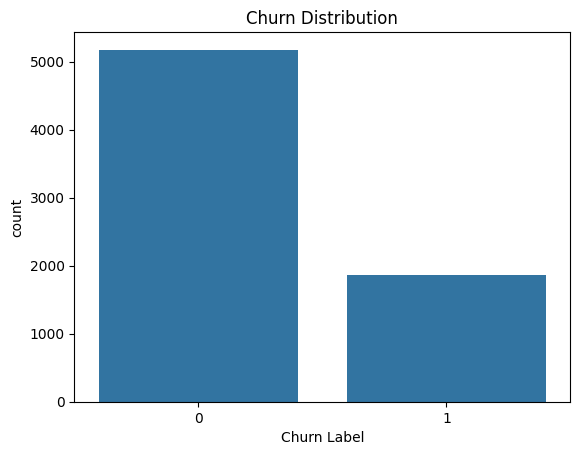

Accuracy: 0.9524485450674237
Precision: 0.8987012987012987
Recall: 0.9251336898395722
F1: 0.9117259552042161
ROC-AUC: 0.9915781859515875

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1035
           1       0.90      0.93      0.91       374

    accuracy                           0.95      1409
   macro avg       0.94      0.94      0.94      1409
weighted avg       0.95      0.95      0.95      1409



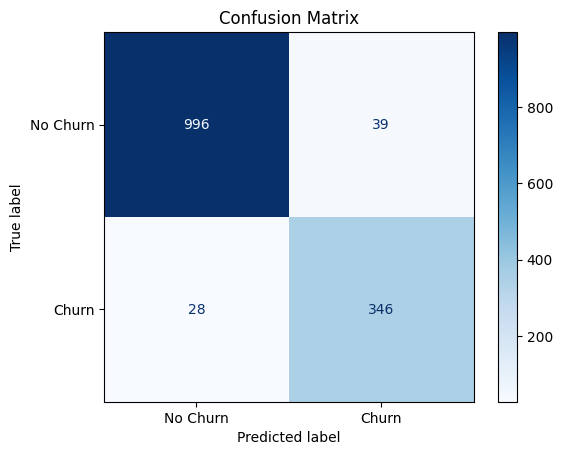

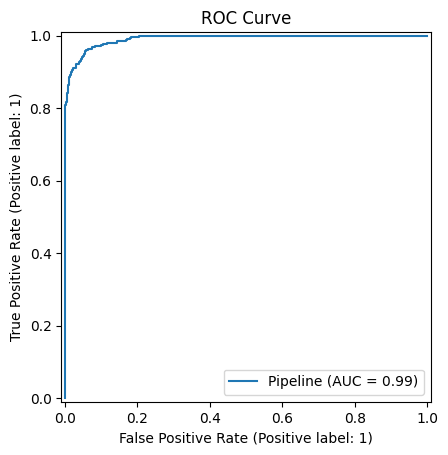

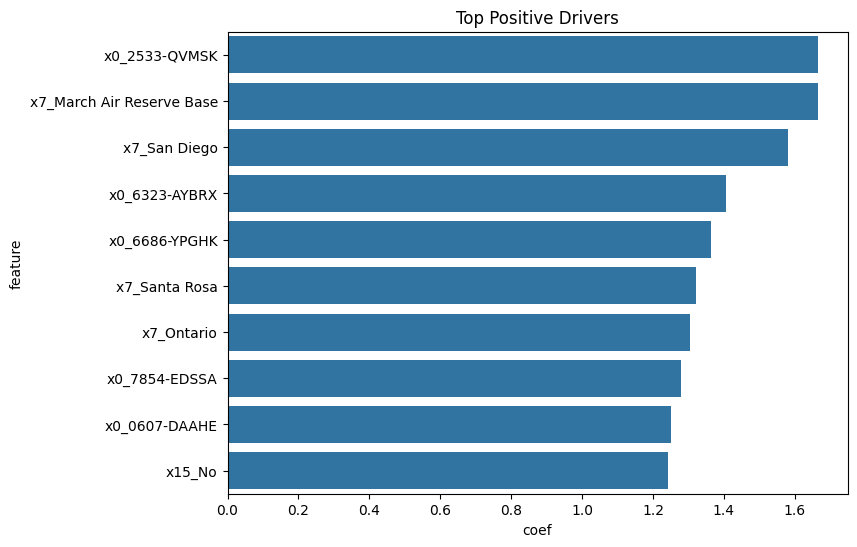

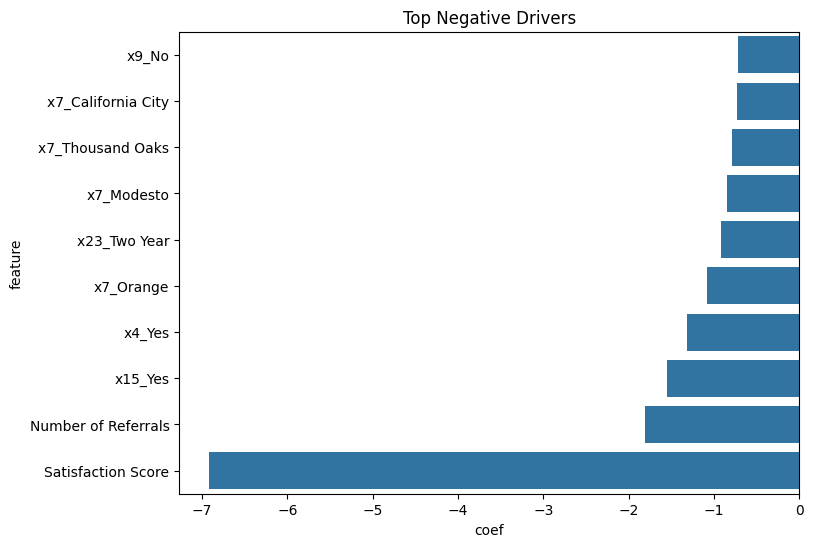

Results saved to final_output.xlsx


In [2]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)

warnings.filterwarnings('ignore')

# load dataset
df = pd.read_csv("telco.csv")
print("Shape of data:", df.shape)
print(df.head())

# clean up TotalCharges
if "Total Charges" in df.columns:
    df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")

# SeniorCitizen column (0/1 to Yes/No)
if "Senior Citizen" in df.columns:
    df["Senior Citizen"] = df["Senior Citizen"].map({1: "Yes", 0: "No"})

# set target column manually (assuming it's called Churn)
print("Columns in dataset:", df.columns.tolist())
target_col = "Churn Label"

# remove leakage columns if present
drop_cols = [c for c in ["Churn Score","Churn Category","Churn Reason","Customer Status"] if c in df.columns]
df.drop(columns=drop_cols, inplace=True)

# drop rows with missing target
df = df.dropna(subset=[target_col])

# X / y split
X = df.drop(columns=[target_col])
y = df[target_col].map(lambda x: 1 if str(x).strip().lower() in ["yes","churned"] else 0)

# check target balance
sns.countplot(x=y)
plt.title("Churn Distribution")
plt.show()

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# preprocessing
categorical = X.select_dtypes(include=["object"]).columns.tolist()
numeric = X.select_dtypes(exclude=["object"]).columns.tolist()

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, numeric),
    ("cat", cat_pipe, categorical)
])

# model
model = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
])

model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn","Churn"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()

# feature importance
ohe = model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["ohe"]
cat_features = ohe.get_feature_names_out()
all_features = np.concatenate([numeric, cat_features])

coefs = model.named_steps["clf"].coef_[0]
feat_imp = pd.DataFrame({"feature": all_features, "coef": coefs}).sort_values("coef", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="coef", y="feature", data=feat_imp.head(10))
plt.title("Top Positive Drivers")
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(x="coef", y="feature", data=feat_imp.tail(10))
plt.title("Top Negative Drivers")
plt.show()

# save outputs to excel (3 sheets)
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_proba)
}
metrics_df = pd.DataFrame([metrics])

predictions_df = X_test.copy()
predictions_df["True"] = y_test.values
predictions_df["Predicted"] = y_pred
predictions_df["Prob"] = y_proba

with pd.ExcelWriter("final_output.xlsx") as writer:
    metrics_df.to_excel(writer, sheet_name="Metrics", index=False)
    feat_imp.to_excel(writer, sheet_name="Feature_Importance", index=False)
    predictions_df.to_excel(writer, sheet_name="Predictions", index=False)

print("Results saved to final_output.xlsx")
